In [1]:
import os.path as op
from scipy.misc import derivative
from scipy import stats as stats
import pandas as pd
import pandas_flavor as pf
import janitor  as jn # noqa
import numpy as np
import seaborn as sns
import mne
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
from mne import io, combine_evoked, read_source_estimate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas_profiling import ProfileReport


%config InlineBackend.figure_format = "retina"
%matplotlib widget

In [2]:
# PANDAS parameters
pd.options.display.html.table_schema = True
pd.options.display.max_rows = None
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 500)

# %%
@pf.register_dataframe_method
def str_remove(df, column_name: str, pattern: str = ""):
    """Wrapper to remove string patten from a column"""
    df[column_name] = df[column_name].str.replace(pattern, "")
    return df


@pf.register_dataframe_method
def explode(df: pd.DataFrame, column_name: str, sep: str):
    """Wrapper to expand column after text processing"""
    df["id"] = df.index
    wdf = (
        pd.DataFrame(df[column_name].str.split(sep).fillna("").tolist())
        .stack()
        .reset_index()
    )
    # exploded_column = column_name
    wdf.columns = ["id", "depth", column_name]  # plural form to singular form
    # wdf[column_name] = wdf[column_name].apply(lambda x: x.strip())  # trim
    wdf.drop("depth", axis=1, inplace=True)

    return pd.merge(df, wdf, on="id", suffixes=("_drop", "")).drop(
        columns=["id", column_name + "_drop"]
    )

/var/folders/t_/1wqwsggn7ts11gm4pbbtg2br0000gn/T/ipykernel_29200/3867837577.py:17: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'explode' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def explode(df: pd.DataFrame, column_name: str, sep: str):


In [4]:
# Workspace parameters
seed = np.random.seed(42)
mrsi_data = "/Users/ktavabi/Documents/Projects/paros-bids/static/all_nbwr_mrs_results_csfcorr_fits_20180417.xlsx"
# https://github.com/ydataai/pandas-profiling/issues/954
study_name = "paros-bids"
bids_root = "/Volumes/LaCie/paros-bids"
deriv_root = f"{bids_root}/derivatives/bids-pipeline"
subjects_dir = "/Volumes/LaCie/freesurfer"

f = pd.ExcelFile(mrsi_data)
data = f.parse(sheet_name="FSLcorr_metab", header=1)
df = data.clean_names().str_remove("subject", pattern="sub-nbwr")
pivot_long_on = df.columns.values[1:]
df = df.pivot_longer(
    column_names=pivot_long_on,
    names_to="name",
    values_to="value",
    sort_by_appearance=True)

df[["hemisphere", "mrsi"]] = df.name.apply(
    lambda x: pd.Series(str(x).split("_", 1)))

df.drop(labels=["name"], axis=1, inplace=True)
df = df.reorder_columns(["subject", "hemisphere", "mrsi", "value"]).encode_categorical(column_names=["hemisphere", "mrsi"])
df["grp"] = df["subject"].apply(lambda x: "asd" if np.int16(x) < 400 else "td")
df["hemisphere"] = df["hemisphere"].map({"left": "lh", "right": "rh"})
df = df[df.subject != "307"]
df = pd.pivot_table(df, values = "value", index=["subject", "hemisphere", "grp"], columns=["mrsi"]).reset_index()
df.head()

subjects = df["subject"].unique()
print(subjects)
meg_data = np.zeros((len(subjects), 2, 2, 1))  # subjects*conditions*hemisphere
_df = jn.expand_grid(others={"subject":subjects, "condition":[1,2], "hemisphere":["lh", "rh"]})

for si, subject in enumerate(subjects):
    for ci, condition in enumerate(["lexical", "nonlex"]):
        stc =  read_source_estimate(op.join(deriv_root, f"sub-{subject}", "meg",
            f"sub-{subject}_task-lexicaldecision_{condition}+dSPM+morph2fsaverage+hemi-lh.stc"))
        for hii, hem in enumerate(["lh", "rh"]):
            _, meg_data[si, ci, hii] = stc.crop(tmin=.150, tmax=.500).get_peak(hemi=hem)

l,m,n,r = meg_data.shape
stc_data = meg_data.reshape(l*m*n,1)
stc_data = pd.DataFrame(stc_data, columns =["latency"])  # unlabeled
df_meg = pd.concat([_df, stc_data], axis=1, ignore_index=True).clean_names()
df_meg = df_meg.rename_columns(new_column_names={"0":"subject", "1":"condition", "2":"hemisphere", "3":"latency"})
df_meg.info()
dataset = pd.merge(df, df_meg, on=["subject", "hemisphere"], how="inner")
dataset.head()
dataset.describe()


['007' '017' '038' '081' '088' '107' '110' '132' '135' '136' '144' '215'
 '226' '301' '309' '317' '401' '404' '405' '407' '409' '421' '426' '427'
 '428' '431' '432' '437' '440' '442' '443' '444' '447' '448' '449' '451']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject     144 non-null    object 
 1   condition   144 non-null    int64  
 2   hemisphere  144 non-null    object 
 3   latency     144 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


,crpluspcr,gaba,gabaovercr,glu_80ms,gluovergaba,gpcpluspch,mins,naaplusnaag,condition,latency
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,6.065681,0.981434,0.047528,8.100722,8.471704,1.610674,3.603512,7.507307,1.500000,0.370514
std,0.514025,0.157194,0.007673,0.710083,1.604701,0.178300,0.484942,0.644952,0.501745,0.126176
min,4.742436,0.565572,0.030000,6.807346,5.775330,1.248529,2.492036,5.582126,1.000000,0.150000
25%,5.725038,0.892228,0.043000,7.550846,7.412994,1.494325,3.246060,7.195641,1.000000,0.236000
50%,6.031224,0.977656,0.047500,8.030199,8.306936,1.632334,3.610998,7.478566,1.500000,0.437000
75%,6.450188,1.081062,0.052000,8.563594,9.064902,1.713093,3.994132,7.983126,2.000000,0.480000
max,7.180294,1.409455,0.068000,10.143852,13.806604,2.049463,4.604937,9.330908,2.000000,0.500000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject      144 non-null    object 
 1   hemisphere   144 non-null    object 
 2   grp          144 non-null    object 
 3   crpluspcr    144 non-null    float64
 4   gaba         144 non-null    float64
 5   gabaovercr   144 non-null    float64
 6   glu_80ms     144 non-null    float64
 7   gluovergaba  144 non-null    float64
 8   gpcpluspch   144 non-null    float64
 9   mins         144 non-null    float64
 10  naaplusnaag  144 non-null    float64
 11  condition    144 non-null    int64  
 12  latency      144 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 15.8+ KB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

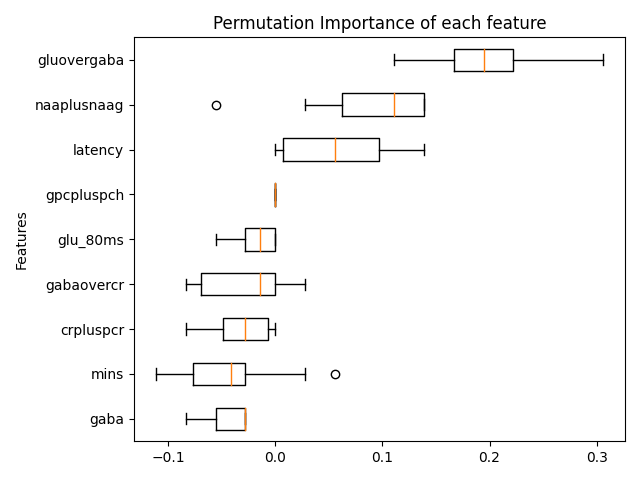

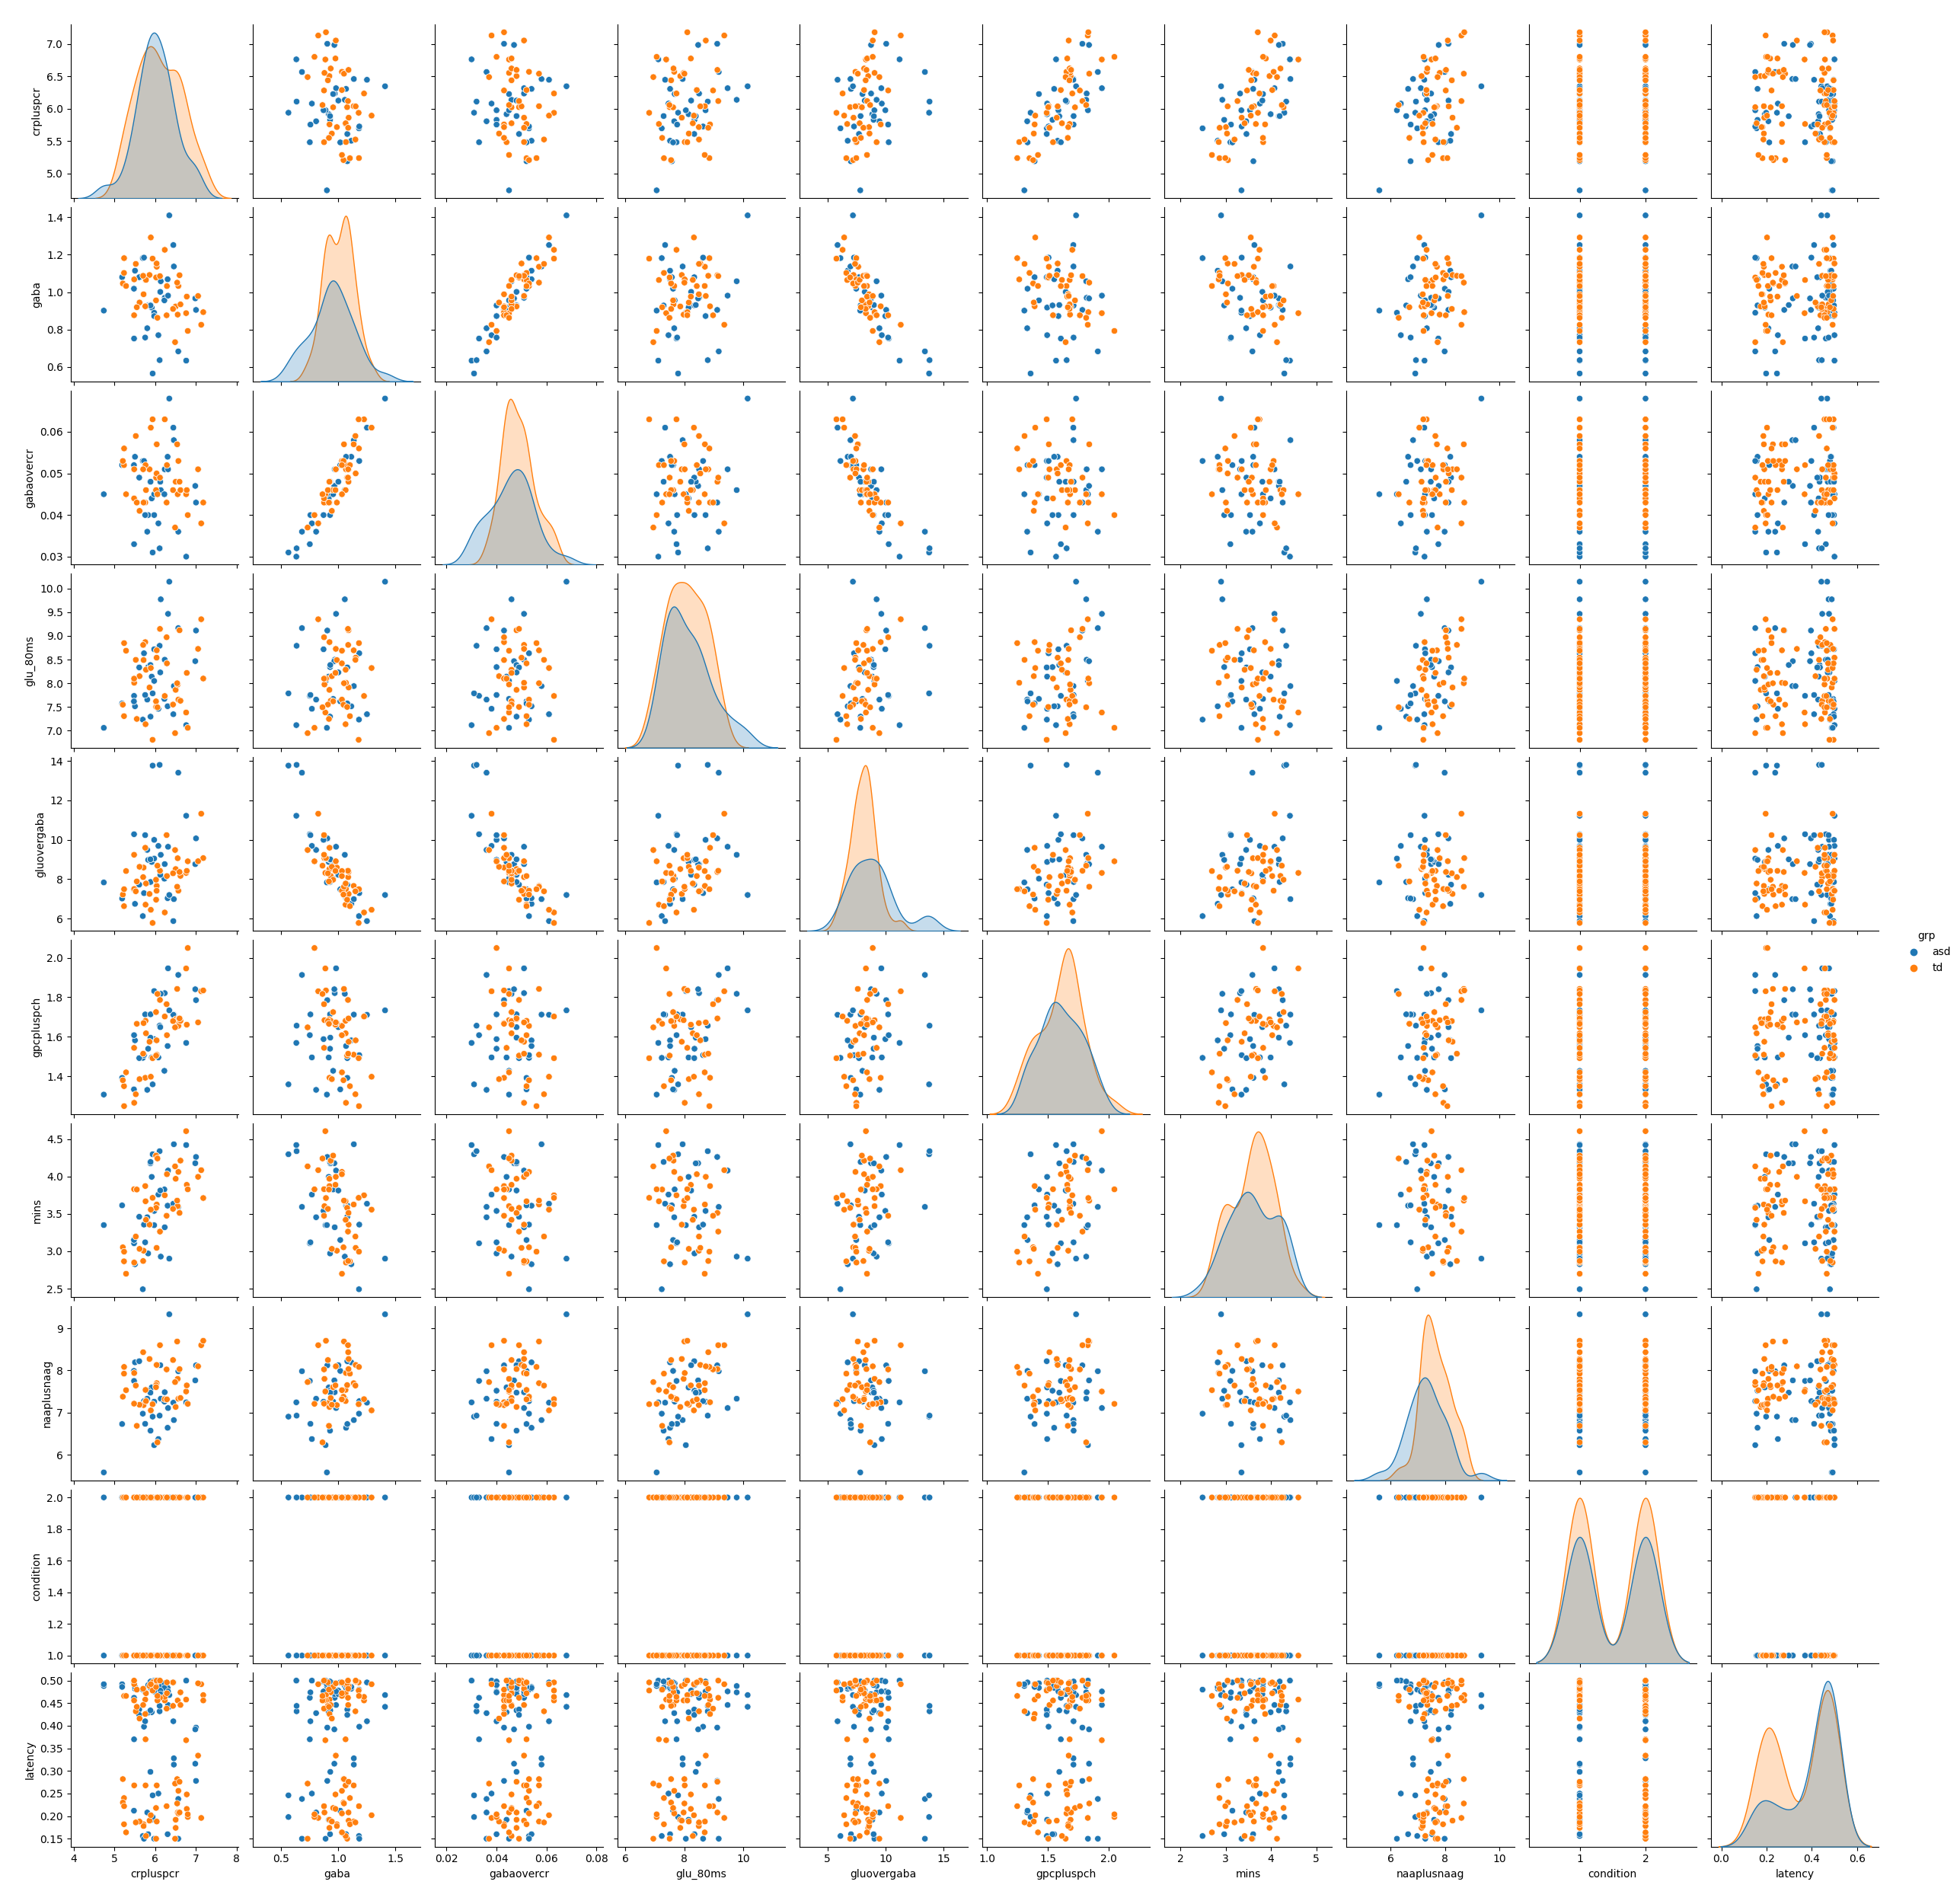

In [5]:
dataset.info()
profile = ProfileReport(dataset, title="Pandas Profiling Report", vars={"num": {"low_categorical_threshold": 0}}, explorative=True)
profile.to_file("profile.html")
sns.pairplot(dataset, hue='grp')
dataset.columns


# create a pipeline object
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression()
 )
X = dataset[['crpluspcr', 'gaba', 'gabaovercr', 'glu_80ms', 'gluovergaba', 'gpcpluspch', 'mins', 'naaplusnaag', 'latency']].values
X.shape
Y = dataset["grp"].map({"asd": 1, "td": 2}).values
Y.shape
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed)
model = pipe.fit(X_train, y_train)
model_accuracy = accuracy_score(pipe.predict(X_test), y_test)
model_accuracy
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=seed)

# %%
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
feature_names = np.array(['crpluspcr', 'gaba', 'gabaovercr', 'glu_80ms', 'gluovergaba', 'gpcpluspch', 'mins', 'naaplusnaag', 'latency'])
sorted_idx = result.importances_mean.argsort()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

# The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled [1].

# [1] L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

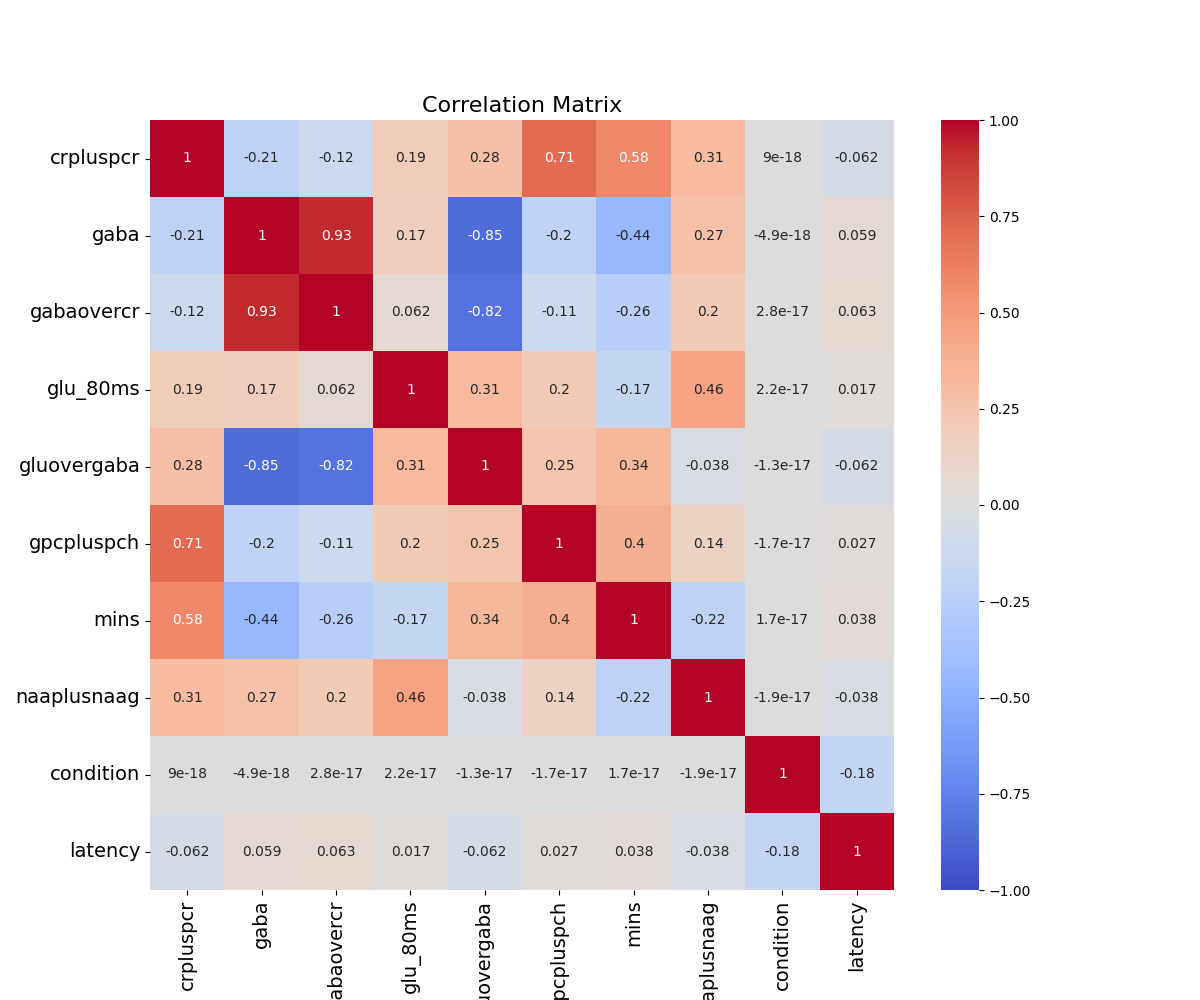

In [6]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(dataset.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

In [8]:
model_accuracy

0.7222222222222222